In [58]:
!pip install keras_self_attention
!pip install pandas==0.24.0

You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Lambda, concatenate, Input, GlobalMaxPooling1D, GlobalAveragePooling1D
import keras.backend as K
import pandas as pd
import json
import pickle
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from models import AudioCNNModel, AudioLSTMModel, AudioCNNPopularityModel, BaselineFullyConnectedNet
import time

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

Using TensorFlow backend.


In [4]:
np.random.seed()

In [5]:
num_frames = 599
num_freq_bins = 128
dummy_data = np.random.random((num_frames, num_freq_bins))
num_conv_filters_1 = 128
kernel_size = 4
num_genres = 18
embedding_dimension=300


In [72]:
#Get popularity data
# popularity_df = pd.read_pickle("data/nn_subset_popularity.pkl")
# popularity_df = pd.read_csv("data/nn_subset_popularity.csv", sep=",")
with open('data/nn_subset_popularity_dict.pkl', 'rb') as f:
    popularity_dict = pickle.load(f)
with open("data/track_ids.txt", "r") as f:
    track_ids = f.readlines()
    

In [101]:
# # print(track_ids[0].split()[0])"
# print(popularity_dict[track_ids[0].split()[0]])
#DON'T RUN THIS AFTER YOU ALREADY HAVE POPULARITY
y_pop = []
for t_id in track_ids:
    if t_id.strip() == '':
        continue
    y_pop += [popularity_dict[t_id.strip()]]
    
y_pop = np.array(y_pop)
print(y_pop.shape)
# np.save(open("data/popularity.npy", "wb"), y_pop)

(32648,)


In [6]:
with open("data/mfcc.npy", "rb") as f:
    mfcc_features = np.load(f)
with open("data/chroma.npy", "rb") as f:
    chroma_features = np.load(f)
with open("data/genre_onehot.npy", "rb") as f:
    y = np.load(f)
with open("data/embeddings.npy", "rb") as f:   
    embeddings = np.load(f)
with open("data/popularity.npy", "rb") as f:
    y_pop = np.load(f)
print(mfcc_features.shape)
print(y.shape)
print(y_pop.shape)

(32648, 300, 12)
(32648, 18)
(32648,)


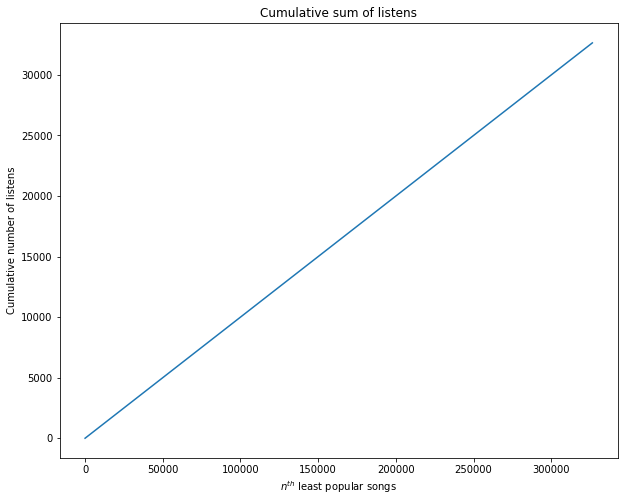

In [96]:
y_pop_sorted = np.sort(y_pop)
y_pop_cum = np.cumsum(y_pop_sorted)
plt.figure(figsize=(10,8))
plt.plot(y_pop_cum)
plt.title("Cumulative sum of listens")
plt.xlabel("$n^{th}$ least popular songs")
plt.ylabel("Cumulative number of listens")
plt.show()

In [95]:
print(np.min(y_pop), np.max(y_pop))
#bin y_pop
bins = np.percentile(y_pop, np.arange(0,100,10))
print(bins)
indices = np.digitize(y_pop, bins[1:])
print(np.sum(indices==1))
onehot = np.zeros((indices.size, indices.max() + 1))
onehot[np.arange(indices.size),indices] = 1.0
y_pop = onehot
print(y_pop.shape)

124 726885
[ 124.   156.   198.   258.   336.   451.   622.   891.9 1430.6 2792.3]
3267
(32648, 10)


In [7]:
chromaTrain, chromaTest, mfccTrain, mfccTest, embeddingsTrain, embeddingsTest, yTrain, yTest, ypopTrain, ypopTest = train_test_split(chroma_features, mfcc_features, embeddings, y, y_pop, test_size = 0.2)
print(chromaTrain.shape, yTrain.shape)

print(yTest.shape)

(26118, 300, 12) (26118, 18)
(6530, 18)


In [8]:
genre_mask = {}
for i in range(18):
    genre_mask[i] = []
for i in range(yTrain.shape[0]):
    genre_mask[yTrain[i].argmax()] += [i]

mfcc_new = []
chroma_new = []
embeddings_new = []
y_new = []
for i in range(18):
    if len(genre_mask[i]) <= 10:
        continue
    replace = True
    if len(genre_mask[i]) >= 1000:
        replace = False
    indices = np.random.choice(genre_mask[i], size=1000, replace=replace)
    if i == 1:
        indices = np.random.choice(genre_mask[i], size=4000, replace=replace)
    mfcc_new += [mfccTrain[indices]]
    chroma_new += [chromaTrain[indices]]
    embeddings_new += [embeddingsTrain[indices]]
    y_new += [yTrain[indices]]

    
print(yTrain.shape)
mfccTrain = np.concatenate(mfcc_new)
chromaTrain = np.concatenate(chroma_new)
embeddingsTrain = np.concatenate(embeddings_new)
yTrain = np.concatenate(y_new)

print(mfccTrain.shape)
print(yTrain.shape)


(26118, 18)
(19000, 300, 12)
(19000, 18)


In [9]:
indices = np.random.permutation(yTrain.shape[0])
mfccTrain = mfccTrain[indices]
chromaTrain = chromaTrain[indices]
embeddingsTrain = embeddingsTrain[indices]
yTrain = yTrain[indices]

In [10]:
model = AudioCNNModel(300, 12, num_conv_filters_1, 4, kernel_size, num_genres, embedding_dimension, lambda1=0.01, lambda2=0.01)
# model = AudioLSTMModel(num_lstm_layers=2, LSTM_hidden_state_dim=10, num_frames=300, num_freq_bins=12, num_genres=18, lyrics_embedding_dimension=300, use_attention=False, lambda1=0.01, lambda2=0.01)
# model = AudioCNNPopularityModel(300, 12, num_conv_filters_1, 4, kernel_size, num_genres, embedding_dimension, lambda1=0.01, lambda2=0.01)
# model = BaselineFullyConnectedNet(300, 12, num_conv_filters_1, 4, kernel_size, num_genres, embedding_dimension, lambda1=0.01, lambda2=0.01)


Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.net.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['accuracy'])
# model.net.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['mean_squared_error'])

In [12]:
history = model.net.fit([chromaTrain, mfccTrain, embeddingsTrain], yTrain, validation_split=0.3, epochs=30, batch_size=10)
# history = model.net.fit([chromaTrain, mfccTrain, embeddingsTrain], ypopTrain, validation_split=0.3, epochs=20, batch_size=100)


Instructions for updating:
Use tf.cast instead.
Train on 13300 samples, validate on 5700 samples
Epoch 1/30
13300/13300 [==============================] - 18s 1ms/step - loss: 12.6059 - acc: 0.2851 - val_loss: 3.7424 - val_acc: 0.3044
Epoch 2/30
13300/13300 [==============================] - 16s 1ms/step - loss: 2.9913 - acc: 0.3155 - val_loss: 2.6230 - val_acc: 0.3370
Epoch 3/30
13300/13300 [==============================] - 16s 1ms/step - loss: 2.5442 - acc: 0.3319 - val_loss: 2.4533 - val_acc: 0.3486
Epoch 4/30
13300/13300 [==============================] - 16s 1ms/step - loss: 2.4713 - acc: 0.3353 - val_loss: 2.4259 - val_acc: 0.3474
Epoch 5/30
13300/13300 [==============================] - 16s 1ms/step - loss: 2.4147 - acc: 0.3438 - val_loss: 2.4216 - val_acc: 0.3198
Epoch 6/30
13300/13300 [==============================] - 16s 1ms/step - loss: 2.3735 - acc: 0.3510 - val_loss: 2.4224 - val_acc: 0.3304
Epoch 7/30
13300/13300 [==============================] - 16s 1ms/step - loss: 2

In [102]:
print(model.net.evaluate([chromaTrain, mfccTrain, embeddingsTrain], ypopTrain))
print(model.net.evaluate([chromaTest, mfccTest, embeddingsTest], ypopTest))

26118/26118 [==============================] - 11s 413us/step
[3.0217866747145066, 0.1161650968692014]
6530/6530 [==============================] - 3s 428us/step
[3.022645347954486, 0.10949464012251149]


In [13]:
print(model.net.evaluate([chromaTrain, mfccTrain, embeddingsTrain], yTrain))
print(model.net.evaluate([chromaTest, mfccTest, embeddingsTest], yTest))
print(model.net.evaluate([np.random.permutation(chromaTest), np.random.permutation(mfccTest), np.random.permutation(embeddingsTest)], yTest))

19000/19000 [==============================] - 3s 170us/step
[1.3863511199951173, 0.7341578947368421]
6530/6530 [==============================] - 1s 167us/step
[2.8975420943080556, 0.3762633996937213]
6530/6530 [==============================] - 1s 167us/step
[4.977164271706644, 0.20581929555895864]


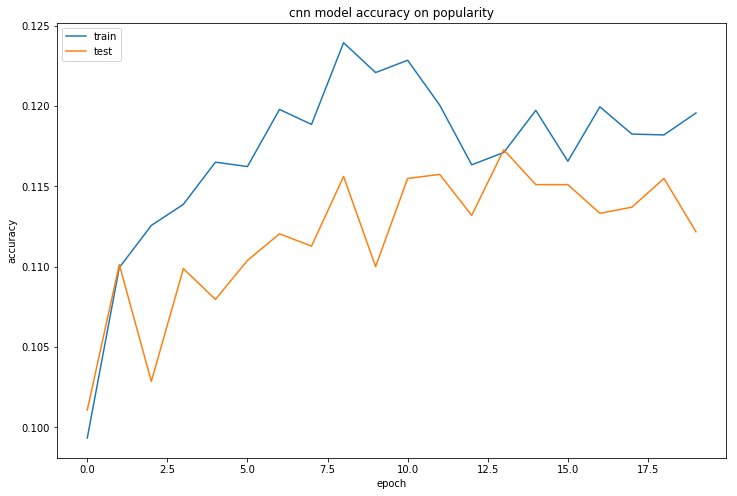

In [103]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('cnn model accuracy on popularity')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

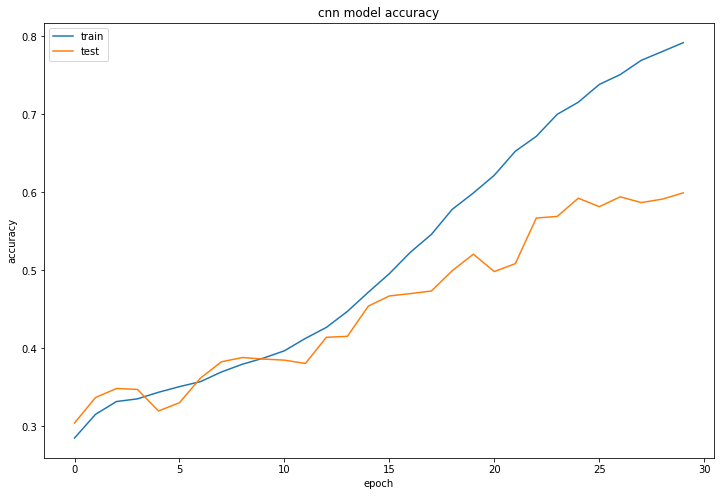

In [14]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('cnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

{'Reggae': 1000, 'Rock': 4000, 'Pop_Rock': 1000, 'Metal': 1000, 'World': 1000, 'International': 0, 'RnB': 1000, 'Jazz': 1000, 'Punk': 1000, 'Vocal': 0, 'Latin': 1000, 'Pop': 1000, 'Rap': 1000, 'Country': 1000, 'New': 1000, 'Blues': 1000, 'Electronic': 1000, 'Folk': 1000}


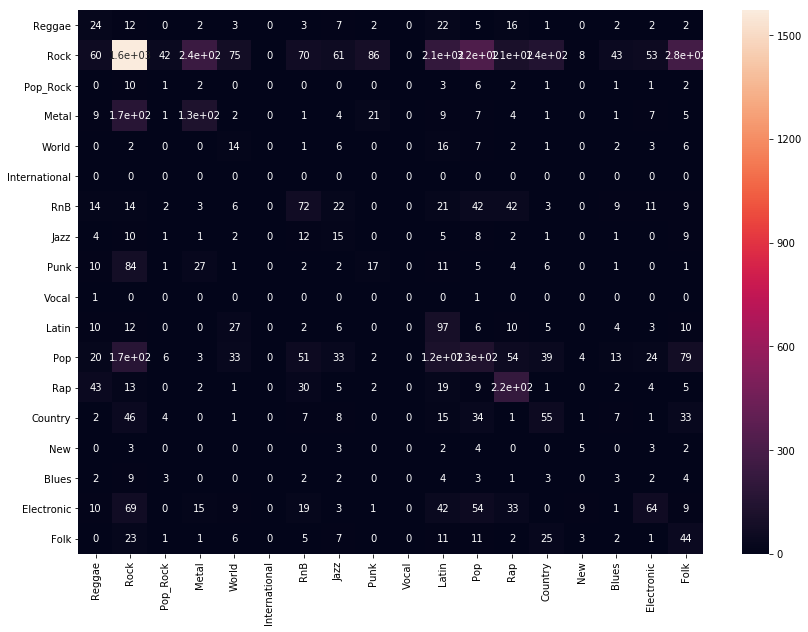

In [15]:
genre_list = ['Reggae', 'Rock', 'Pop_Rock', 'Metal', 'World', 'International', 'RnB', 'Jazz', 'Punk', 'Vocal', 'Latin', 'Pop', 'Rap', 'Country', 'New', 'Blues', 'Electronic', 'Folk']
# print(genre_list)
ypred = model.net.predict([chromaTest, mfccTest, embeddingsTest])
# ypred = model.net.predict([chromaTrain, mfccTrain, embeddingsTrain])
confMatrix = confusion_matrix(yTest.argmax(axis=1), ypred.argmax(axis=1), labels=np.arange(0,18,1))
df_cm = pd.DataFrame(confMatrix, index=genre_list, columns=genre_list)
# print(confMatrix.shape)
# print(yTest.shape)
# print(ypred.shape)
# print(np.sum(yTest, axis=0))
# print(np.sum(ypred, axis=0))
plt.figure(figsize=(14,10))
sn.heatmap(df_cm, annot=True)
# print(confMatrix)
genre_counts = {}
for genre in genre_list:
    genre_counts[genre] = 0
for sample in yTrain:
    genre_counts[genre_list[sample.argmax()]] += 1
print(genre_counts)

In [16]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 18
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(yTest[:, i],
                                                        ypred[:, i])
    average_precision[i] = average_precision_score(yTest[:, i], ypred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(yTest.ravel(),
    ypred.ravel())
average_precision["micro"] = average_precision_score(yTest, ypred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))
f1 = sklearn.metrics.f1_score(yTest.argmax(axis=1), ypred.argmax(axis=1), labels=np.arange(0,18,1), average='micro')
print('F1 score: {0:0.2f}'.format(f1))

Average precision score, micro-averaged over all classes: 0.32
F1 score: 0.38


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.32')

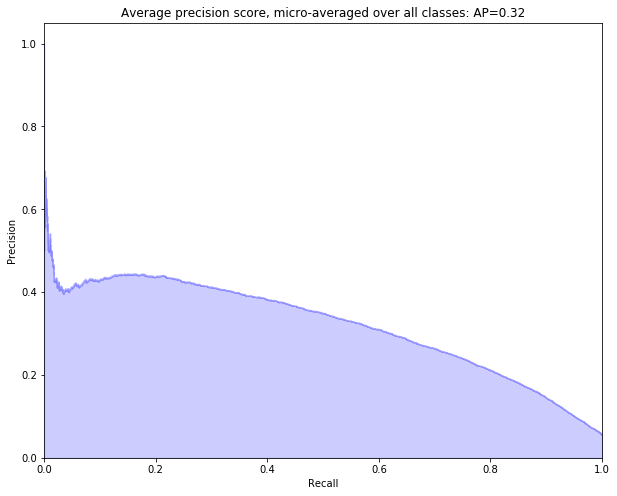

In [17]:
plt.figure(figsize=(10,8))
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [87]:
model_json = model.net.to_json()
with open('params/model_params_CNN_low_overfit_genre_v5.json', "w") as f:
    f.write(model_json)
model.net.save_weights("params/model_params_CNN_low_overfit_genre_v5.h5")

In [104]:
latent_embeddings = model.embedding.predict([chroma_features, mfcc_features, embeddings])

In [67]:
print(latent_embeddings.shape)

(32648, 50)


In [105]:
np.save(open("data/popularity_latent_embeddings.npy", "wb"), latent_embeddings)

In [ ]:
with open('data/embedding.pickle', "rb") as f:
    u = pickle.load(f)
print(len(u))
with open('data/embedding_ids.pickle', "rb") as f:
    v = pickle.load(f)
print(len(v))
print(v[0])

In [ ]:
embeddings_dict = {}
for i in range(len(v)):
    embeddings_dict[v[i]] = u[i]


In [ ]:
  
f = open("data/track_ids.txt", "r")
track_ids = f.readlines()
f.close()
print(track_ids[0].strip())

with open("data/mfcc.npy", "rb") as f:
    mfcc_features = np.load(f)
with open("data/chroma.npy", "rb") as f:
    chroma_features = np.load(f)
with open("data/genre_onehot.npy", "rb") as f:
    y = np.load(f)
# y = y.reshape((int(y.shape[0]/num_genres), num_genres))
print(y.shape) 
print(mfcc_features.shape)
relevant_track_ids = []
embeddings = []
delete_indices = []
for i in range(len(track_ids)):
    if i%1000==0:
        print(i)
    if embeddings_dict.get(track_ids[i].strip()) is not None:
        embeddings += [np.array(embeddings_dict[track_ids[i].strip()])[0]]
        relevant_track_ids += [track_ids[i]]
    else:
        delete_indices += [i]
        
chroma_features = np.delete(chroma_features, delete_indices, axis=0)
mfcc_features = np.delete(mfcc_features, delete_indices, axis=0)
y = np.delete(y, delete_indices, axis=0)

embeddings = np.array(embeddings)
print(embeddings.shape)

In [ ]:
embeddings = np.array(embeddings)
print(embeddings.shape)
print(mfcc_features.shape)
print(y.shape)

In [ ]:
print(len(relevant_track_ids))
print(len(list(set(relevant_track_ids))))

In [ ]:
np.save(open("data/chroma.npy", "wb"), chroma_features)
np.save(open("data/mfcc.npy", "wb"), mfcc_features)
np.save(open("data/genre_onehot.npy", "wb"), y)
np.save(open("data/embeddings.npy", "wb"), embeddings) 
f = open("data/track_ids.txt", "w")
for track in relevant_track_ids:
    f.write(track+"\n")
f.close()

In [ ]:
  
f = open("data/track_ids.txt", "r")
track_ids = f.readlines()
print(len(track_ids))
s = set(track_ids)
print(len(list(s)))
f.close()

In [ ]:
!pip install pydot
from keras.utils.vis_utils import plot_model
plot_model(model.net, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [1]:
import keras
from keras_self_attention import SeqSelfAttention

Using TensorFlow backend.


In [ ]:
import keras
from keras_self_attention import SeqSelfAttention

class AudioLSTMModel():
    def __init__(self, num_lstm_layers, LSTM_hidden_state_dim, num_time_frames, num_freq_bins, num_genres, lyrics_embedding_dimension, use_attention):
        
        self.num_time_frames = num_time_frames

        self.chroma_input = Input(shape=(num_frames, num_freq_bins))
        self.mfcc_input = Input(shape=(num_frames, num_freq_bins))
        self.lyrics_embedding_input = Input(shape=(embedding_dimension,))
        self.use_attention = use_attention
        
        
        # chroma LSTM and attention
        chroma = keras.layers.LSTM(units=LSTM_hidden_state_dim, return_state=True, input_shape=(self.num_frames, self.num_freq_bins))(self.chroma_input)
        for _ in range(num_lstm_layers - 1):
            chroma = keras.layers.LSTM(units=LSTM_hidden_state_dim, return_state=True)(chroma)
        
        if self.use_attention:
            chroma = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL, name='AttentionChroma')(chroma)
        
        # MFCC LSTM and attetion
        mfcc = keras.layers.LSTM(units=LSTM_hidden_state_dim, return_state=True, input_shape=(self.num_frames, self.num_freq_bins))(self.mfcc_input)
        for _ in range(num_lstm_layers - 1):
            mfcc = keras.layers.LSTM(units=LSTM_hidden_state_dim, return_state=True)(mfcc)
        
        if self.use_attention:
            mfcc = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL, name='AttentionMFCC')(mfcc)
                
        
        # concatinating the mfcc chroma and embedding features
        x = concatenate([mfcc, chroma, self.embedding_input])

        # putting the features through a couple fcnn. 
        x = Dense(2048, activation='relu')(x)
        x = Dense(2048, activation='relu')(x)
        
        # the embedding vector for each song. 
        latent_embedding = Dense(50, activation='relu', name='embedding')(x)
        genre = Dense(num_genres, activation='softmax')(latent_embedding)
        self.net = Model(inputs=[self.chroma_input, self.mfcc_input, self.embedding_input], outputs=genre)
        self.embedding = Model(self.net.input, outputs=self.net.get_layer('embedding').output)